In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.spatial.transform import Rotation as R
from diff_gaussian_rasterization import rasterize, rasterize_jit
import matplotlib.pyplot as plt

In [82]:
key = jax.random.PRNGKey(3)

def render_with_param_transform( means3D, colors_precomp, opacity, scales, rotations,
           image_width, image_height, fx,fy, cx,cy,near,far):
    color = rasterize(
        means3D, colors_precomp, opacity, jnp.exp(scales), rotations,
        image_width, image_height, fx,fy, cx,cy,near,far
    )
    return color


def loss( means3D, colors_precomp, opacity, scales, rotations,
    image_width, image_height, fx,fy, cx,cy,near,far, color_gt):
    color = render_with_param_transform(
        means3D, colors_precomp, opacity, scales, rotations,
        image_width, image_height, fx,fy, cx,cy,near,far
    )
    return jnp.sum(0.5 * (color[:3] - color_gt[:3])**2)

loss_grad = jax.jit(jax.value_and_grad(loss, argnums=(0,1,2,3,4,)), static_argnums=(5,6,7,8,9,10,11,12,))

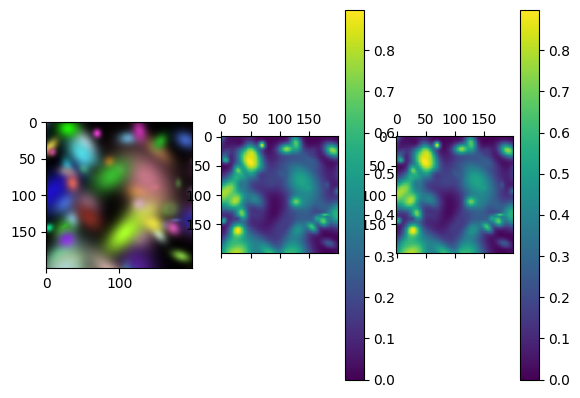

In [87]:
image_width, image_height, fx, fy, cx, cy, near, far = 200, 200, 300.0, 300.0, 100.0, 100.0, 0.01, 2.5

N = 100
key = jax.random.split(key, 2)[0]
means3D = jax.random.uniform(key, shape=(N, 3), minval=-0.5, maxval=0.5) + jnp.array([0.0, 0.0, 1.0])
N = means3D.shape[0]
key = jax.random.split(key, 1)[0]
colors_precomp = jax.random.uniform(key, shape=(N,3), minval=0.0, maxval=1.0)
opacity = jnp.ones(shape=(N,1)) * 1.0
scales =jnp.ones((N,3)) * -3.0
rotations = jax.random.uniform(key, shape=(N,4), minval=-1.0, maxval=1.0)

color_gt = render_with_param_transform(
    means3D, colors_precomp, opacity, scales, rotations,
    image_width, image_height, fx,fy, cx,cy,near,far
)
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
ax1.imshow(jnp.transpose(color_gt[:3,...], (1,2,0)))
im = ax2.matshow(color_gt[3,...])
fig.colorbar(im, ax=ax2)
im = ax3.matshow(color_gt[4,...])
fig.colorbar(im, ax=ax3)

# fig.colorbar(im, cax=ax3, orientation='vertical')


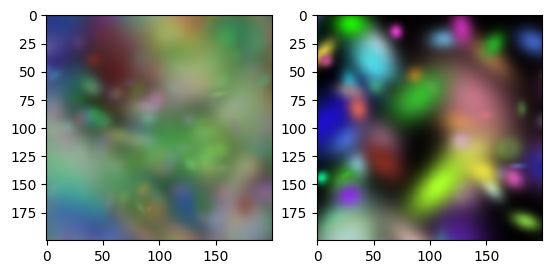

In [93]:
N = 500
key = jax.random.split(key, 1)[0]
means3D = jax.random.uniform(key, shape=(N, 3), minval=-0.5, maxval=0.5) + jnp.array([0.0, 0.0, 1.0])
N = means3D.shape[0]
key = jax.random.split(key, 1)[0]
colors_precomp = jax.random.uniform(key, shape=(N,3), minval=0.0, maxval=1.0)
opacity = jnp.ones(shape=(N,1)) * 0.5
scales =jnp.ones((N,3)) * -3.0
rotations = jax.random.uniform(key, shape=(N,4), minval=-1.0, maxval=1.0)

color = render_with_param_transform(
    means3D, colors_precomp, opacity, scales, rotations,
    image_width, image_height, fx,fy, cx,cy,near,far
)

fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color[:3], (1,2,0)))
ax2.imshow(jnp.transpose(color_gt[:3], (1,2,0)))

loss: 8293.8359: 100%|██████████| 300/300 [00:01<00:00, 262.91it/s]


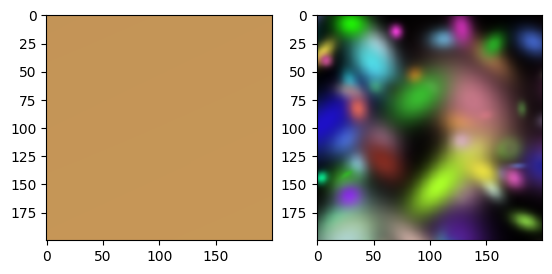

In [92]:
import optax

params = (means3D, colors_precomp, opacity, scales, rotations)
param_labels = ("means3D", "colors_precomp", "opacity", "scales", "rotations")
tx = optax.multi_transform(
    {
        'means3D': optax.sgd(0.001),
        'colors_precomp': optax.sgd(0.001),
        'opacity': optax.sgd(0.0001),
        'scales': optax.sgd(0.0001),
        'rotations': optax.sgd(0.0001),
    },
    param_labels
)
state = tx.init(params)

from tqdm import tqdm

pbar = tqdm(range(300))
for _ in pbar:
    loss,gradients = loss_grad(
        *params,
        image_width, image_height, fx,fy, cx,cy,near,far, color_gt
    )
    # (dL_dmeans3D, dL_dcolors, dL_dopacity, dL_dscales, dL_drotations)
    pbar.set_description(f"loss: {loss:.4f}")
    updates, new_state = tx.update(gradients, state, params)
    params = optax.apply_updates(params, updates)
    # print(loss)
    # print([jnp.max(jnp.abs(u)) for u in gradients])

    color = rasterize_jit(
        *params,
        image_width, image_height, fx,fy, cx,cy,near,far
    )

    # means3D = means3D - dL_dmeans3D  * 0.00001
    # colors_precomp = colors_precomp - dL_dcolors[:,:3]  * 0.0001
    # scales = scales - dL_dscales  * 0.0001
    # rotations = rotations - dL_drotations  * 0.0001
    # opacity = opacity - dL_dopacity  * 0.00001

fix, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jnp.transpose(color[:3], (1,2,0)))
ax2.imshow(jnp.transpose(color_gt[:3], (1,2,0)))

In [49]:
for i in (dL_dmeans3D, dL_dcolors, dL_dopacity, dL_dscales, dL_drotations):
    print(i.max())

1623.9447
568.0372
725.157
3319.4941
372.4254


In [34]:
dL_drotations

Array([[-0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-3.0493399e-02, -4.2889040e-02, -5.9972703e-03, -1.7740371e-02],
       [ 1.2542481e-05, -2.1382648e-06,  1.7884394e-04, -4.2101314e-05],
       [ 6.9988594e+04,  5.5961230e+04,  6.5621883e+04, -4.6978203e+04]],      dtype=float32)

In [34]:
gradients[1].sum()

Array(-322.9931, dtype=float32)